In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import sys

from tensorflow.examples.tutorials.mnist import input_data

import tensorflow as tf

import os.path
import tarfile

import numpy as np
from six.moves import urllib
import glob
import scipy.misc
import math

mnist = input_data.read_data_sets('MNIST_data/', one_hot=True)

def get_inception_score(sample_test): 
    # Create the model
    x = tf.placeholder(tf.float32, [None, 784])
    W = tf.Variable(tf.zeros([784, 10]))
    b = tf.Variable(tf.zeros([10]))
    y = tf.matmul(x, W) + b
    softmax = tf.nn.softmax(y)

    # Define loss and optimizer
    y_ = tf.placeholder(tf.float32, [None, 10])

    # The raw formulation of cross-entropy,
    #
    #   tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(tf.nn.softmax(y)),
    #                                 reduction_indices=[1]))
    #
    # can be numerically unstable.
    #
    # So here we use tf.nn.softmax_cross_entropy_with_logits on the raw
    # outputs of 'y', and then average across the batch.
    cross_entropy = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
    train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

    sess = tf.InteractiveSession()
    tf.initialize_all_variables().run()
    # Train
    for _ in range(1000):
        batch_xs, batch_ys = mnist.train.next_batch(100)
        sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

    # Test trained model
    correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    #print(sess.run(accuracy, feed_dict={x: mnist.test.images,
    #                                  y_: mnist.test.labels}))


    #Inception score
    images = list(sample_test)
    splits = 10
    assert(type(images) == list)
    assert(type(images[0]) == np.ndarray)
    #assert(len(images[0].shape) == 3)
    #assert(np.max(images[0]) > 10)
    assert(np.min(images[0]) >= 0.0)
    inps = []
    for img in images:
        img = img.astype(np.float32)
        inps.append(np.expand_dims(img, 0))
    bs = 100
    preds = []
    n_batches = int(math.ceil(float(len(inps)) / float(bs)))
    for i in range(n_batches):
        sys.stdout.write(".")
        sys.stdout.flush()
        inp = inps[(i * bs):min((i + 1) * bs, len(inps))]
        inp = np.concatenate(inp, 0)
        pred = sess.run(softmax, {x : inp})
        preds.append(pred)
    preds = np.concatenate(preds, 0)
    scores = []
    for i in range(splits):
      part = preds[(i * preds.shape[0] // splits):((i + 1) * preds.shape[0] // splits), :]
      kl = part * (np.log(part) - np.log(np.expand_dims(np.mean(part, 0), 0)))
      kl = np.mean(np.sum(kl, 1))
      scores.append(np.exp(kl))
    #print(np.mean(scores), np.std(scores))
    return np.mean(scores)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

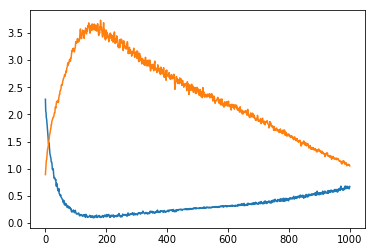

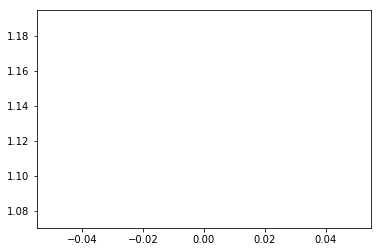

Iter: 1000; D loss: 0.6734; G_loss: 1.052; Inception_score: 1.132; penalty: 0.001048
Instructions for updating:
Use `tf.global_variables_initializer` instead.
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

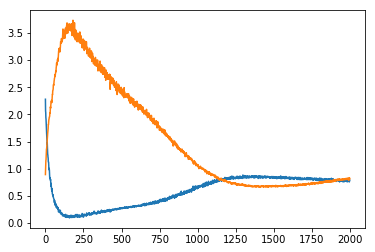

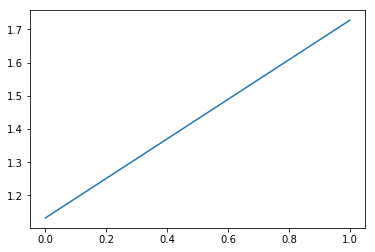

Iter: 2000; D loss: 0.7885; G_loss: 0.815; Inception_score: 1.727; penalty: 0.001116
Instructions for updating:
Use `tf.global_variables_initializer` instead.
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

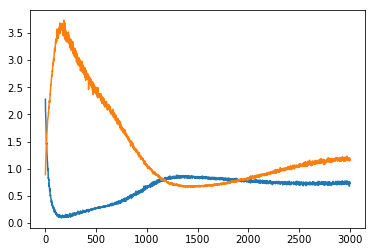

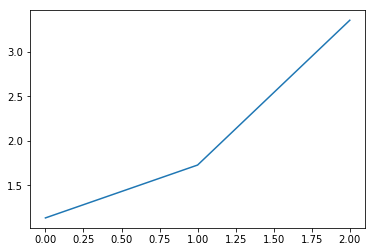

Iter: 3000; D loss: 0.7323; G_loss: 1.178; Inception_score: 3.356; penalty: 0.002122
Instructions for updating:
Use `tf.global_variables_initializer` instead.
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

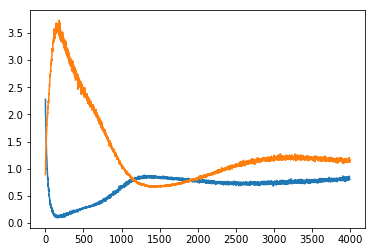

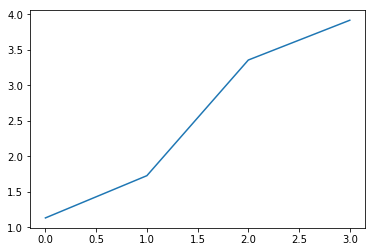

Iter: 4000; D loss: 0.8039; G_loss: 1.173; Inception_score: 3.916; penalty: 0.001624
Instructions for updating:
Use `tf.global_variables_initializer` instead.
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

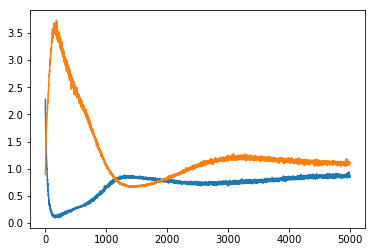

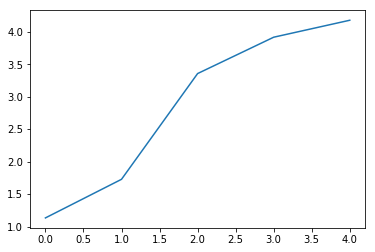

Iter: 5000; D loss: 0.8474; G_loss: 1.11; Inception_score: 4.178; penalty: 0.001978
Instructions for updating:
Use `tf.global_variables_initializer` instead.
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

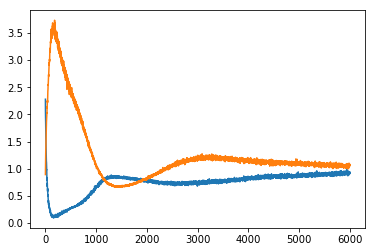

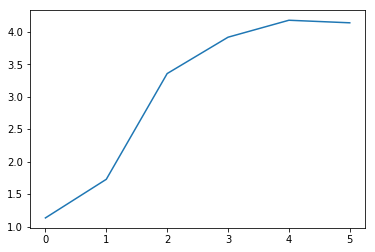

Iter: 6000; D loss: 0.9273; G_loss: 1.075; Inception_score: 4.138; penalty: 0.00157
Instructions for updating:
Use `tf.global_variables_initializer` instead.
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

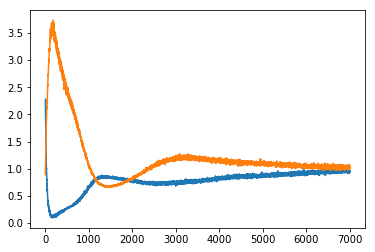

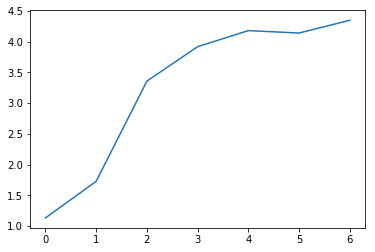

Iter: 7000; D loss: 0.9577; G_loss: 1.002; Inception_score: 4.346; penalty: 0.002029


In [ ]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import math

mb_size = 128
X_dim = 784
z_dim = 100
h_dim = 128

lambd = 10

mnist = input_data.read_data_sets('MNIST_data/', one_hot=True)

def get_perturbed_batch(minibatch):
    return minibatch + 0.5 * minibatch.std() * np.random.random(minibatch.shape)

def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

X = tf.placeholder(tf.float32, shape=[None, X_dim])
X_p = tf.placeholder(tf.float32, shape=[None, X_dim])

D_W1 = tf.Variable(xavier_init([X_dim, h_dim]))
D_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

D_W2 = tf.Variable(xavier_init([h_dim, 1]))
D_b2 = tf.Variable(tf.zeros(shape=[1]))

theta_D = [D_W1, D_W2, D_b1, D_b2]

z = tf.placeholder(tf.float32, shape=[None, z_dim])

G_W1 = tf.Variable(xavier_init([z_dim, h_dim]))
G_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

G_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
G_b2 = tf.Variable(tf.zeros(shape=[X_dim]))

theta_G = [G_W1, G_W2, G_b1, G_b2]

def sample_z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])

def generator(z):
    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)
    return G_prob

def discriminator(x):
    D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)
    out = tf.matmul(D_h1, D_W2) + D_b2
    return out

G_sample = generator(z)
D_real = discriminator(X)
D_fake = discriminator(G_sample)
D_real_perturbed = discriminator(X_p)

D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real, targets=tf.ones_like(D_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake, targets=tf.zeros_like(D_fake)))
disc_cost = D_loss_real + D_loss_fake 
gen_cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake, targets=tf.ones_like(D_fake)))

#Gradient penalty
alpha = tf.random_uniform(
    shape=[mb_size,1], 
    minval=0.,
    maxval=1.
)
differences = X_p - X
interpolates = X + (alpha*differences)
gradients = tf.gradients(discriminator(interpolates), [interpolates])[0]
slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1]))
gradient_penalty = tf.reduce_mean((slopes-1.)**2)
disc_cost += lambd*gradient_penalty

gen_train_op = tf.train.AdamOptimizer(learning_rate=1e-4, beta1=0.5, beta2=0.9).minimize(gen_cost, var_list=theta_G)
disc_train_op = tf.train.AdamOptimizer(learning_rate=1e-4, beta1=0.5, beta2=0.9).minimize(disc_cost, var_list=theta_D)

sess = tf.Session()
sess.run(tf.initialize_all_variables())

if not os.path.exists('out/'):
    os.makedirs('out/')

i = 0
plotD = []
plotG = []
plot_inception = []

for it in range(1, 200000):    
    for _ in range(1):
        X_mb, _ = mnist.train.next_batch(mb_size)
        X_mb_p = get_perturbed_batch(X_mb)

        _, D_loss_curr, penalty = sess.run(
            [disc_train_op, disc_cost, gradient_penalty],
            feed_dict={X: X_mb, X_p: X_mb_p, z: sample_z(mb_size, z_dim)}
        )
                  
    _, G_loss_curr = sess.run(
        [gen_train_op, gen_cost],
        feed_dict={z: sample_z(mb_size, z_dim)}
    )

    plotD.append(D_loss_curr)
    plotG.append(G_loss_curr)
    
    if it % 1000 == 0:
        samples = sess.run(G_sample, feed_dict={z: sample_z(16, z_dim)})
        
        fig = plot(samples)
        plt.savefig('out/{}.png'
                    .format(str(i).zfill(3)), bbox_inches='tight')
        i += 1
        plt.close(fig)
       
        sample_test = sess.run(G_sample, feed_dict={z: sample_z(50000, z_dim)})
        
        inception_score = get_inception_score(list(sample_test))
        plot_inception.append(inception_score)
        
        plotDn = np.array(plotD)
        plt.plot(plotDn)
        plotGn = np.array(plotG)
        plt.plot(plotGn)
        plt.show()
        plot_In = np.array(plot_inception)
        plt.plot(plot_In)
        plt.show()
        
    if it % 1000 == 0:
        print('Iter: {}; D loss: {:.4}; G_loss: {:.4}; Inception_score: {:.4}; penalty: {:.4}'
              .format(it, D_loss_curr, G_loss_curr, inception_score, penalty))

